In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

import torch
from torch import nn, optim, tensor
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Anomaly Detection in Time Series using a forecasting model
The aim of this notebook is to perform anomaly detection in time series data, using a forecasting model.

The model should learn to forecast a step of the time series from the previous steps. If this forecast is outside a certain threshold, it is considered an anomaly.

## Opening the data
The data is opened and the train data (first half of the dataset) is defined.

In [2]:
t = pd.read_csv("data/data.csv")
t["timestamp"] = pd.to_datetime(t["timestamp"])
classes = t["anomaly"].unique()
# t["anomaly"] = t["anomaly"].replace(classes[classes > 1], 1)
train_dataset = t[:365*24*60]
train_dataset = train_dataset[train_dataset["anomaly"] == 0]  # only take normal data for forecasting training
train_dataset

,timestamp,temperature,pressure,power,anomaly
0,2022-01-01 00:00:00,15.038183,100.009670,85.280902,0
1,2022-01-01 00:01:00,14.744127,100.014957,85.108418,0
2,2022-01-01 00:02:00,15.021593,100.008126,85.078984,0
3,2022-01-01 00:03:00,15.158443,99.987873,85.225306,0
4,2022-01-01 00:04:00,14.968216,99.983669,84.795304,0
...,...,...,...,...,...
525595,2022-12-31 23:55:00,15.853737,100.014875,89.397116,0
525596,2022-12-31 23:56:00,16.100863,99.988009,88.969575,0
525597,2022-12-31 23:57:00,16.174065,100.020636,89.404697,0
525598,2022-12-31 23:58:00,16.165804,100.006695,88.830585,0


In [3]:
n = 15
X_df = train_dataset[["temperature", "pressure", "power"]]
X_df

,temperature,pressure,power
0,15.038183,100.009670,85.280902
1,14.744127,100.014957,85.108418
2,15.021593,100.008126,85.078984
3,15.158443,99.987873,85.225306
4,14.968216,99.983669,84.795304
...,...,...,...
525595,15.853737,100.014875,89.397116
525596,16.100863,99.988009,88.969575
525597,16.174065,100.020636,89.404697
525598,16.165804,100.006695,88.830585


## Setting the anomaly threshold
The first step is to visualize the data and try to define an optimal threshold for the anomalies.

In [145]:
anomaly_thresholds = np.array([
	1, .06, 2.75])

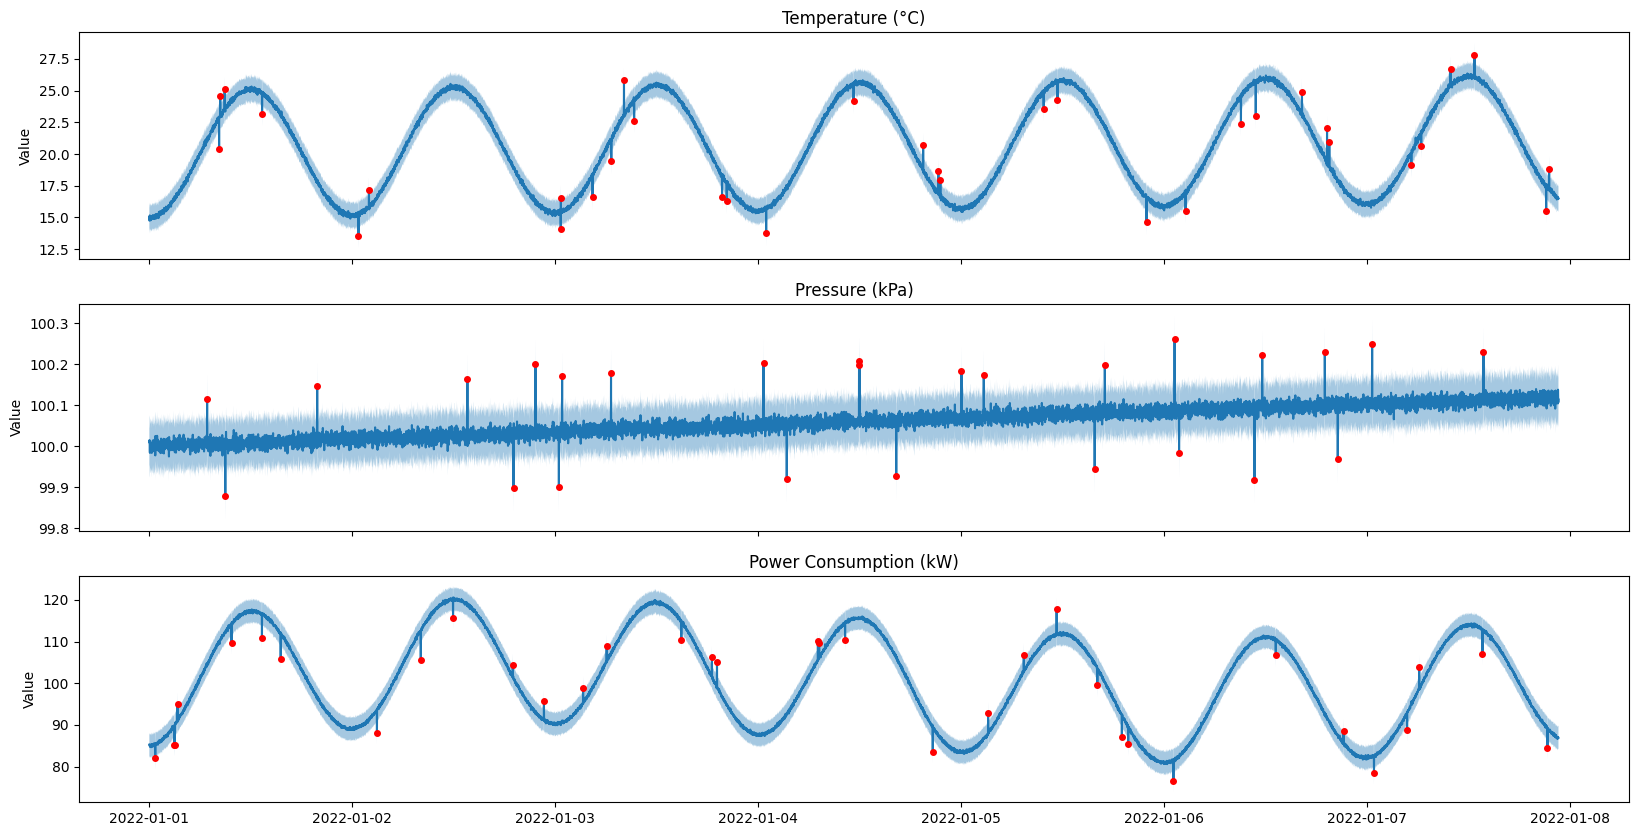

In [146]:
sample_size = 10000
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
variables = ['temperature', 'pressure', 'power']
titles = ['Temperature (°C)', 'Pressure (kPa)', 'Power Consumption (kW)']

for i, (var, title) in enumerate(zip(variables, titles)):
	y = t[:sample_size][var]
	axs[i].fill_between(x=t[:sample_size]["timestamp"], y1=y + anomaly_thresholds[i], y2=y - anomaly_thresholds[i], alpha=.4)
	axs[i].plot(t[:sample_size]["timestamp"], y)
	anomalous_data = t[:sample_size][t[:sample_size]["anomaly"] == (i + 1)]
	axs[i].plot(anomalous_data["timestamp"], anomalous_data[var], marker='o', ms=4, linestyle='', color='red', label="Anomaly")
	axs[i].set_title(title)
	axs[i].set_ylabel('Value')
plt.show()

## Building the dataset
The dataset is normalized and built for the LSTM models below.

In [6]:
X_df_means = X_df.mean().to_numpy()
X_df_stds = X_df.std().to_numpy()
X_df_means, X_df_stds

(array([ 20.50032809,  99.9999893 , 100.0072603 ]),
 array([ 7.70839887,  0.70717824, 13.2318448 ]))

In [7]:
X = (np.array([
	data.to_numpy()
	for data in X_df.rolling(window=n)][n:-1]) - X_df_means) / X_df_stds

Y = (np.roll(X_df.to_numpy(), -n - 1, axis=0)[:-n-1] - X_df_means) / X_df_stds

X.shape, Y.shape

((521515, 15, 3), (521515, 3))

## LSTM Model
A simple LSTM followed by linear layers is used.

In [8]:
class LSTMExtractor(nn.Module):
	def __init__(self):
		super().__init__()
			
	def forward(self, lstm_out: tensor) -> tensor:
		return lstm_out[0][:, -1, :]

In [9]:
class LSTMNet(nn.Module):
	def __init__(self, input_size: int, output_size: int, hidden_size: int = 16, num_layers: int = 2):
		super().__init__()
		self.net = nn.Sequential(
			nn.LSTM(input_size, hidden_size, num_layers, batch_first=True),
			LSTMExtractor(),
			nn.ReLU(),
			nn.Linear(hidden_size, hidden_size),
			nn.ReLU(),
			nn.Linear(hidden_size, output_size),)
		
	def forward(self, x: tensor) -> tensor:
		return self.net(x)

## Training

In [10]:
Xt = torch.from_numpy(X.astype(np.float32))
Yt = torch.from_numpy(Y.astype(np.float32))
Xt.shape, Yt.shape

(torch.Size([521515, 15, 3]), torch.Size([521515, 3]))

In [11]:
dataset = TensorDataset(Xt, Yt)

In [12]:
datasets = [
	TensorDataset(Xt[:, :, i:i+1], Yt[:, i:i+1])
	for i in range(Xt.shape[-1])
]

In [13]:
lr, batch_size, num_epochs = .001, 32, 1

models = [
	LSTMNet(1, 1) 
	for _ in range(Xt.shape[-1])
]
optimizers = [
	optim.Adam(models[i].parameters(), lr=lr)
	for i in range(Xt.shape[-1])
]
dataloaders = [
	DataLoader(datasets[i], batch_size=batch_size, shuffle=True)
	for i in range(Xt.shape[-1])
]
criterion = nn.MSELoss()

In [14]:
def train(model, criterion, dataloader, optimizer):
	losses = []

	for _ in (pbar := tqdm(range(num_epochs), desc="Epoch")):
		for i, (inputs, targets) in enumerate(dataloader):
			out = model(inputs)
	
			loss = criterion(out, targets)
			
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()
	
			with torch.no_grad():
				losses.append(loss.item())
				pbar.set_postfix_str(f"Batch: {100 * i / len(dataloader):.1f}%, Loss: {loss.item()}")
		
	return losses

In [15]:
losses = [
	train(models[i], criterion, dataloaders[i], optimizers[i])
	for i in range(Xt.shape[-1])
]

Epoch: 100%|██████████| 1/1 [03:04<00:00, 184.63s/it, Batch: 100.0%, Loss: 0.000461492600152269]


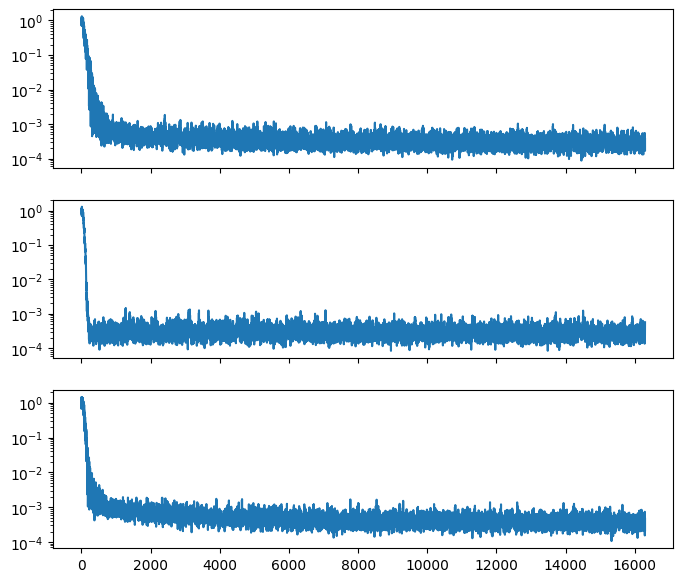

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

for i, l in enumerate(losses):
	axs[i].plot(l)
	axs[i].set_yscale("log")

plt.show()

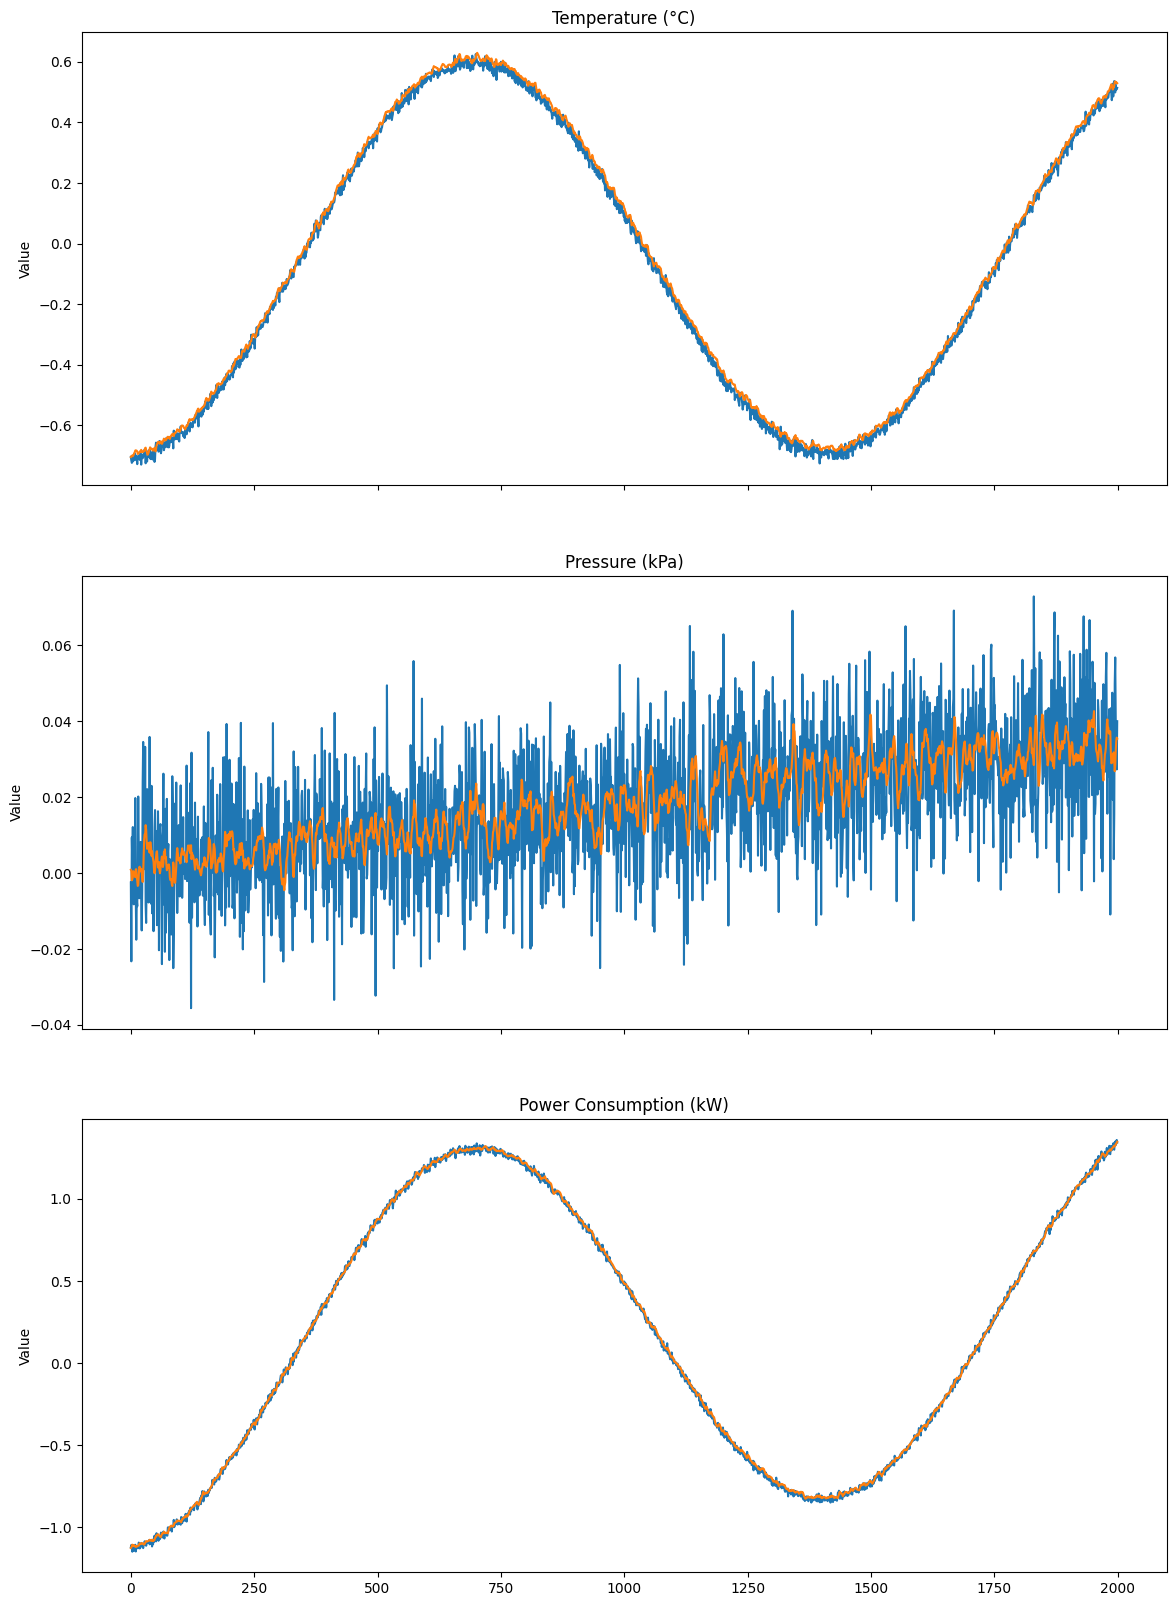

In [17]:
sample_size = 2000  # One week
fig, axs = plt.subplots(3, 1, figsize=(14, 20), sharex=True)
variables = ['temperature', 'pressure', 'power']
titles = ['Temperature (°C)', 'Pressure (kPa)', 'Power Consumption (kW)']

for i, (var, title) in enumerate(zip(variables, titles)):

	with torch.no_grad():
		forecast = models[i](Xt[:sample_size, :, i:i+1])
	axs[i].plot(Y[:sample_size, i])
	axs[i].plot(forecast)
	axs[i].set_title(title)
	axs[i].set_ylabel('Value')
plt.show()

## Thresholds optimization
The next step is to determine the best thresholds between the forecasted value and the observed value.

In [147]:
train_dataset_for_threshold = t[:450000]
train_dataset_for_threshold

,timestamp,temperature,pressure,power,anomaly
0,2022-01-01 00:00:00,15.038183,100.009670,85.280902,0
1,2022-01-01 00:01:00,14.744127,100.014957,85.108418,0
2,2022-01-01 00:02:00,15.021593,100.008126,85.078984,0
3,2022-01-01 00:03:00,15.158443,99.987873,85.225306,0
4,2022-01-01 00:04:00,14.968216,99.983669,84.795304,0
...,...,...,...,...,...
449995,2022-11-09 11:55:00,18.076219,99.225942,103.359903,0
449996,2022-11-09 11:56:00,17.944634,99.218222,103.547698,0
449997,2022-11-09 11:57:00,18.159187,99.215960,103.228941,0
449998,2022-11-09 11:58:00,17.960507,99.233239,103.095086,0


In [148]:
train_data_for_threshold = train_dataset_for_threshold[["temperature", "pressure", "power"]]
train_ground_truth_anomalies = (train_dataset_for_threshold[["anomaly"]][n+1:] > 0)

In [149]:
X_train_for_threshold = (np.array([
	data.to_numpy()
	for data in train_data_for_threshold.rolling(window=n)][n:-1]) - X_df_means) / X_df_stds
X_train_for_threshold.shape

(449984, 15, 3)

In [150]:
observations = train_data_for_threshold[n+1:]
observations.shape

(449984, 3)

In [151]:
with torch.no_grad():
	forecasts = np.concatenate([
		models[i](torch.from_numpy(X_train_for_threshold[:, :, i:i+1]).float())
		for i in range(Xt.shape[-1])], axis=1)
forecasts.shape

(449984, 3)

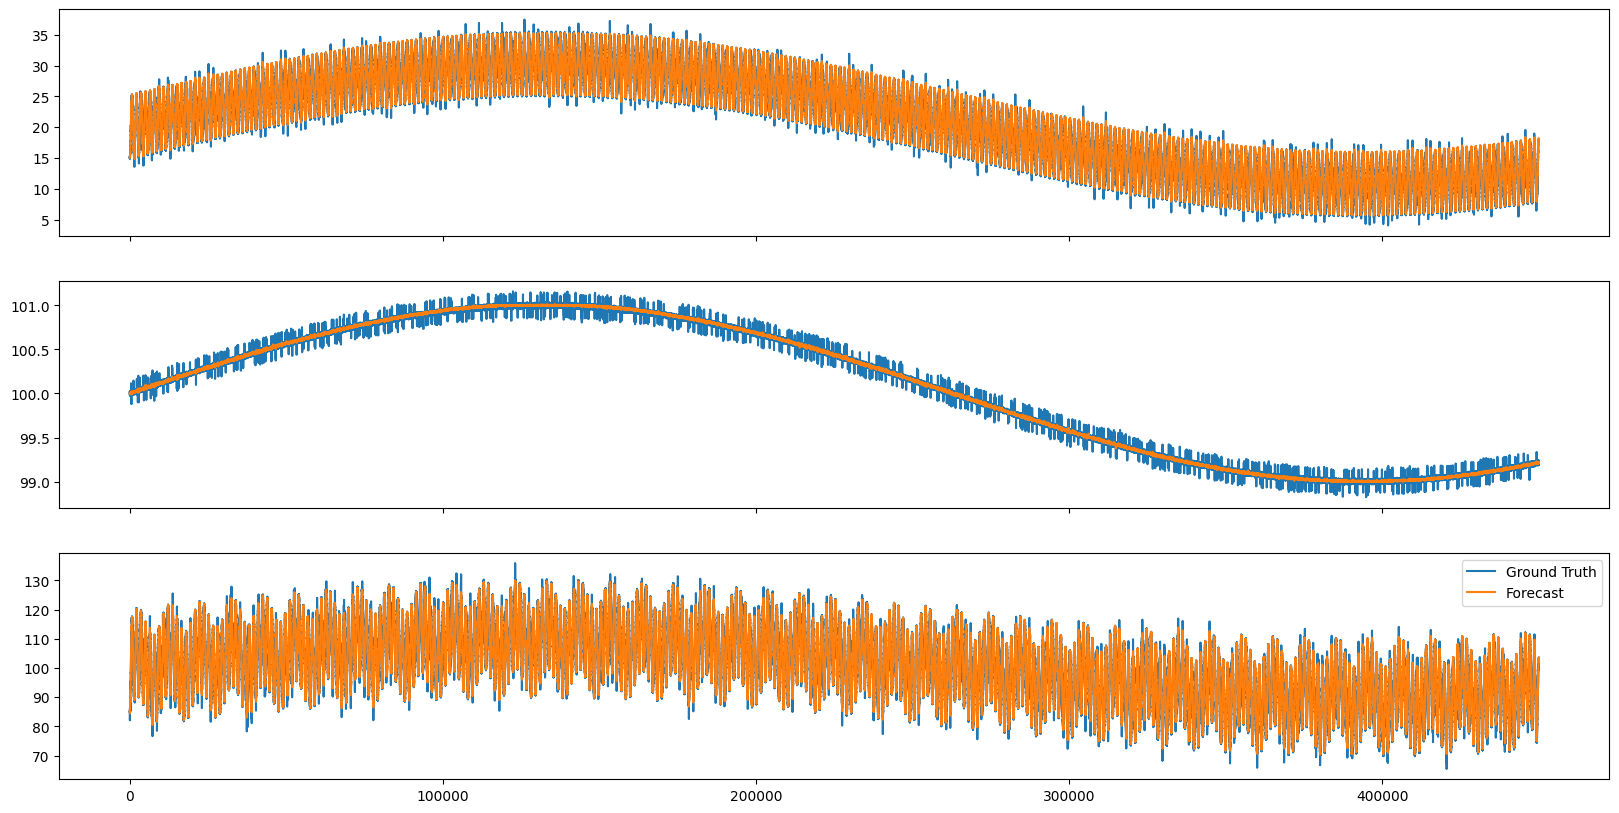

In [152]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
var = ["temperature", "pressure", "power"]

for i, v in enumerate(var):
	axs[i].plot(observations[v].to_numpy(), label="Ground Truth")
	axs[i].plot(forecasts[:, i] * X_df_stds[i] + X_df_means[i], label="Forecast")
	
plt.legend()
plt.show()

In [153]:
diff_obs_pred = (observations - (forecasts * X_df_stds + X_df_means)).abs()
diff_obs_pred

,temperature,pressure,power
16,0.004734,0.002368,0.062410
17,0.112277,0.016898,0.193284
18,0.183151,0.007998,0.080404
19,0.154402,0.002203,0.566633
20,0.015311,0.009364,0.179613
...,...,...,...
449995,0.041607,0.012216,0.008964
449996,0.193272,0.003694,0.165627
449997,0.033327,0.000753,0.231270
449998,0.209793,0.017594,0.342361


## Grid search for the best threshold

In [142]:
temp_thresholds = np.linspace(.5, 1.5, num=11)
pres_thresholds = np.linspace(.05, .15, num=11)
powe_thresholds = np.linspace(1.5, 4, num=11)

best_f1 = 0
best_params = 0, 0, 0  # temp_threshold, pres_threshold, powe_threshold

for te_th in tqdm(temp_thresholds):
		for pr_th in pres_thresholds:
			for po_th in powe_thresholds:
				detected_anomaly = (diff_obs_pred > np.array([te_th, pr_th, po_th])).any(axis=1)
				f1 = f1_score(train_ground_truth_anomalies, detected_anomaly)
				if f1 > best_f1:
					best_f1 = f1
					best_params = te_th, pr_th, po_th
print(f"Best F1-score: {best_f1} with parameters: {best_params}")

100%|██████████| 11/11 [02:42<00:00, 14.80s/it]

Best F1-score: 0.982394878510112 with parameters: (1.0, 0.06, 2.75)


In [154]:
detected_anomaly = ((observations - (forecasts * X_df_stds + X_df_means)).abs() > np.array(best_params)).any(axis=1)
detected_anomaly

16        False
17        False
18        False
19        False
20        False
          ...  
449995    False
449996    False
449997    False
449998    False
449999    False
Length: 449984, dtype: bool

In [155]:
print(f"Accuracy: {accuracy_score(train_ground_truth_anomalies, detected_anomaly):.3f}\nPrecision: {precision_score(train_ground_truth_anomalies, detected_anomaly):.3f}\nRecall: {recall_score(train_ground_truth_anomalies, detected_anomaly):.3f}\nF1-score: {f1_score(train_ground_truth_anomalies, detected_anomaly):.3f}")

Accuracy: 1.000
Precision: 0.991
Recall: 0.975
F1-score: 0.983


## On test data

In [157]:
test_dataset = t[-450000:]
test_data = test_dataset[["temperature", "pressure", "power"]]
test_ground_truth_anomalies = (test_dataset[["anomaly"]][n+1:] > 0)
X_test = (np.array([
	data.to_numpy()
	for data in test_data.rolling(window=n)][n:-1]) - X_df_means) / X_df_stds
test_observations = test_data[n+1:]
with torch.no_grad():
	test_forecasts = np.concatenate([
		models[i](torch.from_numpy(X_test[:, :, i:i+1]).float())
		for i in range(Xt.shape[-1])], axis=1)
detected_anomaly = ((test_observations - (test_forecasts * X_df_stds + X_df_means)).abs() > np.array(best_params)).any(axis=1)
print(f"Accuracy: {accuracy_score(test_ground_truth_anomalies, detected_anomaly):.3f}\nPrecision: {precision_score(test_ground_truth_anomalies, detected_anomaly):.3f}\nRecall: {recall_score(test_ground_truth_anomalies, detected_anomaly):.3f}\nF1-score: {f1_score(test_ground_truth_anomalies, detected_anomaly):.3f}")

Accuracy: 1.000
Precision: 0.987
Recall: 0.978
F1-score: 0.982
